In [76]:
import pickle
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from pprint import pprint
import seaborn as sns

In [343]:
run = 'first_run'
t0 = 1710190050
duration = 100

# Read Sumo positions logs

In [345]:
data = []
with open(f'../logs/{run}/sumo_positions.dat') as fr:
    lines = fr.readlines()
    for row in csv.reader(lines, delimiter=';'):
        data.append({"ts": float(row[1]), "sumo_id": row[2], 'x': float(row[3]), 'y': float(row[4])})
sumo_pos_df = pd.DataFrame(data)
t=sumo_pos_df.pivot_table(values=["x", "y"], index="ts",columns="sumo_id")


# Distance between cars

(0.0, 100.0)

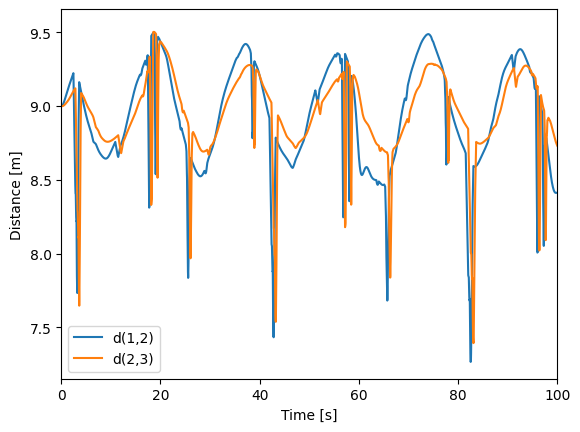

In [347]:

dist_t = t.copy()
dist_t.columns=['x_p.0', 'x_p.1', 'x_p.2', 'y_p.0', 'y_p.1', 'y_p.2']
dist_t['d_p01'] = ((dist_t['x_p.0'] - dist_t['x_p.1'])**2 + (dist_t['y_p.0'] - dist_t['y_p.1'])**2)**(1/2)
dist_t['d_p02'] = ((dist_t['x_p.0'] - dist_t['x_p.2'])**2 + (dist_t['y_p.0'] - dist_t['y_p.2'])**2)**(1/2)
dist_t['d_p21'] = ((dist_t['x_p.2'] - dist_t['x_p.1'])**2 + (dist_t['y_p.2'] - dist_t['y_p.1'])**2)**(1/2)
plt.plot(dist_t.index, dist_t.d_p01, label='d(1,2)')
#plt.plot(t.index, t.d_p02, label='d(1,3)')
plt.plot(dist_t.index, dist_t.d_p21, label='d(2,3)')
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
plt.legend()
plt.xlim(0,duration)

# Speed and Acceleration

Text(0.5, 0, 'Time [s]')

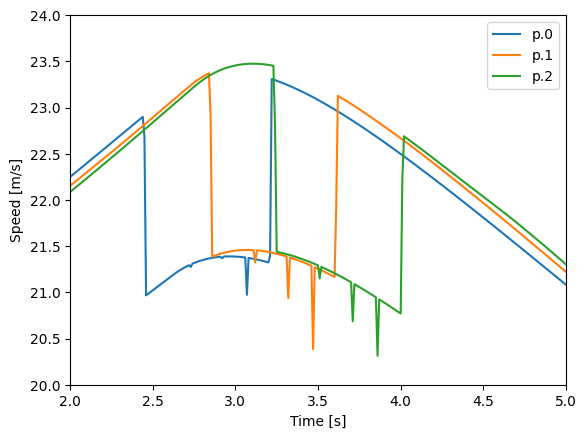

In [348]:
diff = t.diff()

vel = {}
acc = {}
for p in ['p.0', 'p.1', 'p.2']:
    coords = [diff.x[p].values, diff.y[p].values]
    vel[p] = (np.linalg.norm(coords, axis=0)/0.01)[1:]
    acc[p] = vel[p][1:] - vel[p][:-1]

for p in ['p.0', 'p.1', 'p.2']:
    plt.plot(t.index[1:], vel[p], label=p)

plt.legend()
plt.xlim(2,5)
plt.ylim(20,24)
plt.ylabel('Speed [m/s]')
plt.xlabel('Time [s]')



Text(0.5, 0, 'Time [s]')

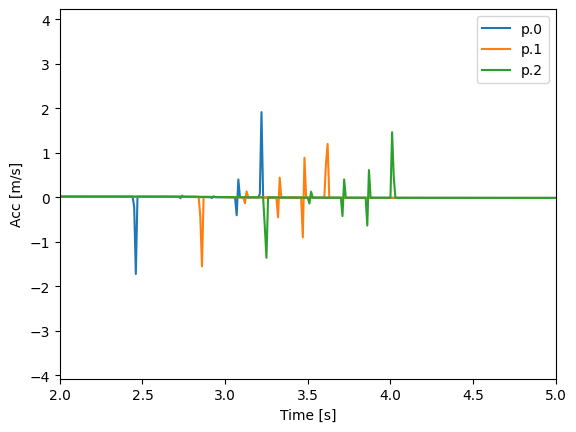

In [350]:
for p in ['p.0', 'p.1', 'p.2']:
    plt.plot(t.index[2:], acc[p], label=p)

plt.legend()
plt.xlim(2,5)
plt.ylabel('Acc [m/s]')
plt.xlabel('Time [s]')


# Read Sumo network logs


In [352]:
def process_row(row):
    if row[0] == 'RX_MSG':
        msg = json.loads(row[3])['content']
        d = {
            'sumo_id': row[2],
            'time': float(row[1]),
            'sender': msg['sender'],
            'recipient': msg['recipient'],
            'sent_at': msg['ts'],
            'delay': (float(row[1])- msg['ts'])*1000,
            'link': f"{msg['sender'][2:]} {msg['recipient'][2:]}"}
        return d

data = []
with open(f'../logs/{run}/p.1.log') as fr:
    lines = fr.readlines()
    for row in csv.reader(lines, delimiter=';'):
        d = process_row(row)
        if d:
            data.append(d)
with open(f'../logs/{run}/p.2.log') as fr:
    lines = fr.readlines()
    for row in csv.reader(lines, delimiter=';'):
        d = process_row(row)
        if d:
            data.append(d)
        

sumo_net_df = pd.DataFrame(data)
#sumo_net_df['time'] = pd.to_datetime(sumo_net_df['time'], unit='s')

/tmp/ipykernel_1199883/10216841.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%H:%M:%S') for tm in xticks],


Text(0.5, 28.999999999999986, '')

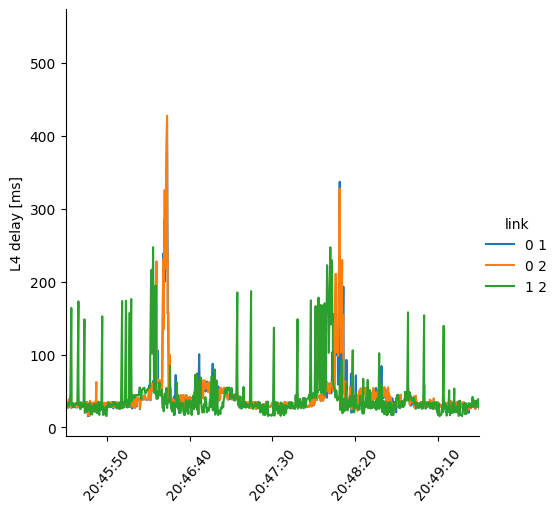

In [353]:
sns.relplot(sumo_net_df, x='time', y='delay', hue='link', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)
# convert all xtick labels to selected format from ms timestamp
ax.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%H:%M:%S') for tm in xticks],
 rotation=50)
ax.set_ylabel("L4 delay [ms]")
ax.set_xlabel("")

# Read OAI logs

In [354]:
def parse_mac(dump):
    for ue_raw in dump.split("UE RNTI")[1:]:
        rnti = ue_raw[1:5] 
        ue_raw_lines = ue_raw.split('\n')
        try:
            rsrp = int(ue_raw_lines[0].split('RSRP')[1][1:4])
        except:
            rsrp = 0
        dl_bler = float(ue_raw_lines[1].split('BLER')[1][1:8])
        ul_bler = float(ue_raw_lines[2].split('BLER')[1][1:8])
        dl_mcs = int(ue_raw_lines[1].split('MCS')[1][5:])
        ul_mcs = int(ue_raw_lines[2].split('MCS')[1][5:])
        tx_bytes = int(ue_raw_lines[3][19:34])
        rx_bytes = int(ue_raw_lines[3][38:53])
        yield {'rnti': rnti, 'tx_bytes': tx_bytes, 'rx_bytes': rx_bytes, 'dl_bler': dl_bler, 'ul_bler':ul_bler, 'dl_mcs':dl_mcs, 'ul_mcs': ul_mcs, 'rsrp': rsrp}
    

with open(f'../logs/{run}/oai_logs.pickle', 'rb') as fb:
    oai_logs = pickle.load(fb)


data = []
for l in oai_logs[10:]:
    if(l['file'] == './nrMAC_stats.log'):  
        metrics = parse_mac(l['content'])
        for m in metrics:
            data.append({
                'time': l['time'],
            } | m)
oai_df = pd.DataFrame(data)

# BLER, MCS

(1710190050.0, 1710190150.0)

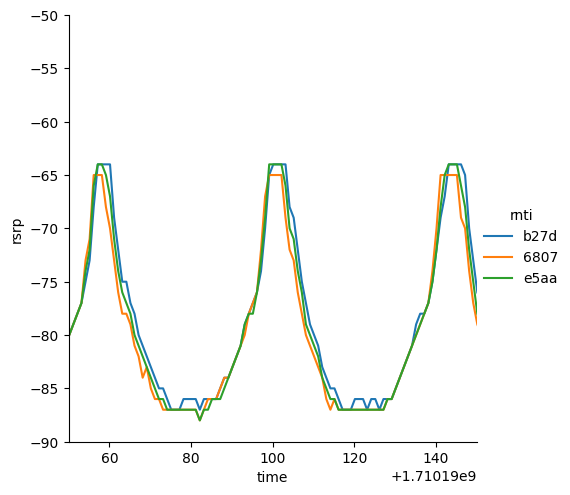

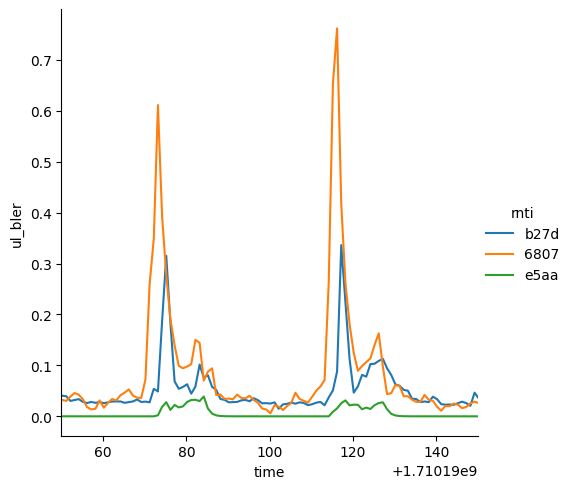

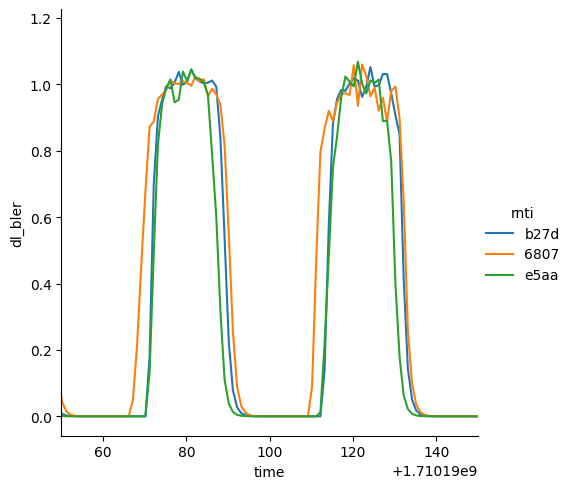

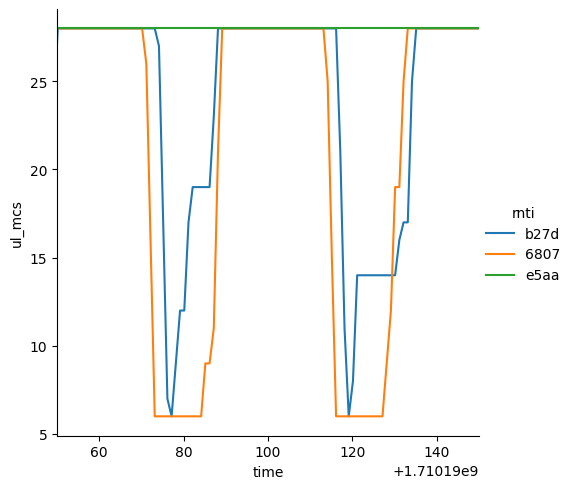

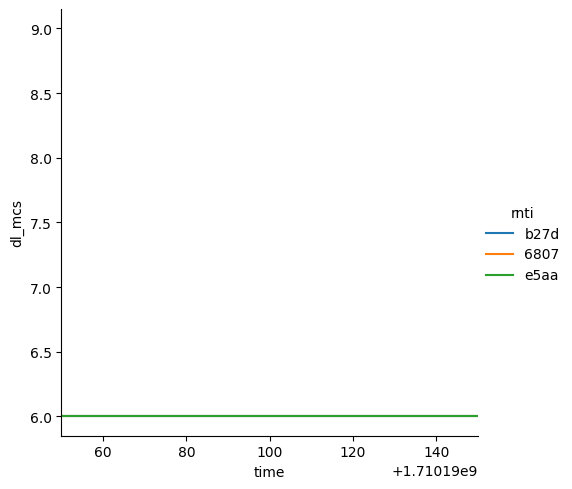

In [356]:
sns.relplot(oai_df, x='time', y='rsrp', hue='rnti', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)
ax.set_ylim(-90, -50)

sns.relplot(oai_df, x='time', y='ul_bler', hue='rnti', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)

sns.relplot(oai_df, x='time', y='dl_bler', hue='rnti', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)

sns.relplot(oai_df, x='time', y='ul_mcs', hue='rnti', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)

sns.relplot(oai_df, x='time', y='dl_mcs', hue='rnti', kind='line')
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
ax.set_xlim(t0, t0+duration)

In [362]:
piv = oai_df.pivot_table(values=['tx_bytes', 'rx_bytes'], index='time', columns='rnti')

thr = piv.diff()/1000
thr_melted = pd.melt(thr, ignore_index=False, value_name='thr')
thr_melted.columns = ['metric', 'rnti', 'thr']

# sns.relplot(thr_melted[(thr_melted.rnti=='6807') & (thr_melted.metric=='rx_bytes')], x='time', y='thr', hue='rnti', kind='line')
# ax = plt.gca()
# # get current xtick labels
# xticks = ax.get_xticks()
# ax.set_xlim(t0, t0+duration)
# ax.set_ylabel("MAC Throughput [kb/s]")

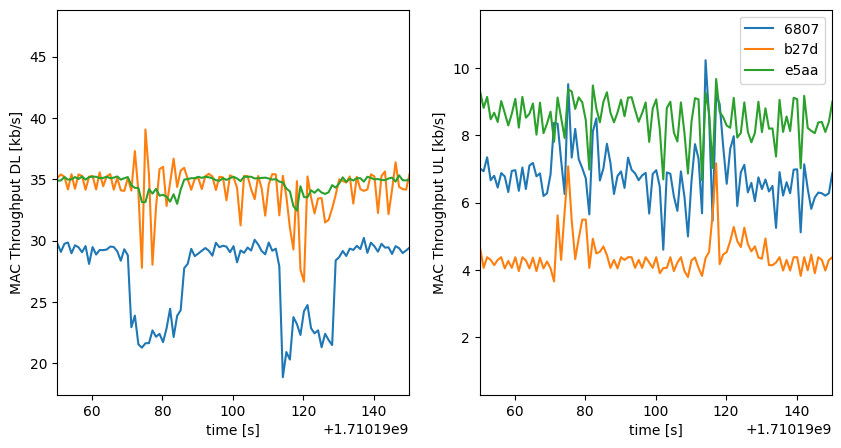

In [361]:
plt.figure(figsize=(10,5))


piv = oai_df.pivot_table(values=['tx_bytes', 'rx_bytes'], index='time', columns='rnti')
thr = piv.diff()/1000


ax1=plt.subplot(1,2,1)
for rnti in ['6807', 'b27d', 'e5aa']:
    ax1.plot(thr.index, thr.rx_bytes[rnti], '-', label=f"{rnti}")


ax2=plt.subplot(1,2,2)
for rnti in ['6807', 'b27d', 'e5aa']:
    ax2.plot(thr.index, thr.tx_bytes[rnti], '-', label=f"{rnti}")

ax1.set_xlim(t0, t0+duration)
ax2.set_xlim(t0, t0+duration)

ax1.set_ylabel("MAC Throughput DL [kb/s]")
ax2.set_ylabel("MAC Throughput UL [kb/s]")

ax1.set_xlabel("time [s]")
ax2.set_xlabel("time [s]")


plt.legend()
